In [2]:
import pandas as pd
df = pd.read_csv("dataset.csv")  
df.head()

,AKM1MP6P0OYPR,132793040,5,1365811200
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


#### Renaming columns

In [3]:
df = df.rename(columns={'AKM1MP6P0OYPR': 'userId', '132793040': 'productId', '5':'rating', '1365811200': 'timestamp'})
print("Shape:", df.shape)

Shape: (695758, 4)


In [4]:
print('No. of unique Users    : ', df['userId'].nunique())
print('No. of unique Products : ', df['productId'].nunique())

No. of unique Users    :  544414
No. of unique Products :  42494


#### NaNs?

In [5]:
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

No NaNs.

In [6]:
df.describe()

,rating,timestamp
count,695758.000000,6.957580e+05
mean,3.976613,1.240480e+09
std,1.398620,1.191511e+08
min,1.000000,9.127296e+08
25%,3.000000,1.146010e+09
50%,5.000000,1.248912e+09
75%,5.000000,1.356653e+09
max,5.000000,1.406074e+09


#### Outliers?

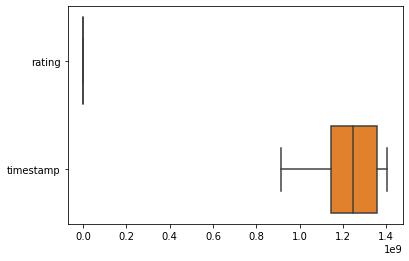

In [7]:
import seaborn as sns
ax = sns.boxplot(data=df, orient='h')

#### What is the distribution of ratings?

In [8]:
df['rating'].value_counts()

5    376492
4    137699
1     84864
3     55234
2     41469
Name: rating, dtype: int64

In [9]:
# Dropping/removing column named 'timestamp'.
df = df.drop(['timestamp'], axis=1)

# Making a copy of "df".
df1 = df.copy()
df1.head()

,userId,productId,rating
0,A2CX7LUOHB2NDG,321732944,5
1,A2NWSAGRHCP8N5,439886341,1
2,A2WNBOD3WNDNKT,439886341,3
3,A1GI0U4ZRJA8WN,439886341,1
4,A1QGNMC6O1VW39,511189877,5


In [24]:
# Creating a new column named 'users_counts' using 'userId'.
users_counts = df1['userId'].value_counts().rename('users_counts')

# Merging
users_data = df1.merge(users_counts.to_frame(), left_on='userId', right_index=True)

# Selecting those having more than or equal to 50 'users_counts'.
subset_df = users_data[users_data.users_counts >= 50]
subset_df.head()

,userId,productId,rating,users_counts
94,A3BY5KCNQZXV5U,0594451647,5.0,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


In [26]:
# Creating a new column named 'product_rating_counts' using 'productId'.
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')

# Merging
product_rating_data = subset_df.merge(product_rating_counts.to_frame(), left_on='productId',
                                      right_index=True)

# Selecting those having more than or equal to 10 'product_rating_counts'.
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,rating,users_counts,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,65,18


In [29]:
# Making a copy of "product_rating_data".
amazon_df = product_rating_data.copy()

# Dropping columns 'users_counts' & 'product_rating_counts'.
panda_data = amazon_df.drop(['users_counts', 'product_rating_counts'], axis=1)
panda_data.head()

,userId,productId,rating
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0


In [33]:
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader

k = 5
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(panda_data[['userId', 'productId', 'rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

### Popularity Recommender model ::- 

- Using mean of product rating
- Using Ranking Based Algorithm

In [34]:
# Grouping 'rating'(mean).
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [35]:
# Grouping 'rating' and sorting in descending order.
panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00006HSML    5.0
B001TH7GUA    5.0
B000IJY8DS    5.0
B005LDLP8W    5.0
Name: rating, dtype: float64

In [36]:
# Grouping 'rating', sorting in descending order and saving it as pandas dataframe.
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False))

# Creating column 'prod_rating_count' by grouping 'productId' and calculating count of product rating.
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())
prod_rating_count.head(k)

,rating,prod_rating_count
productId,,
B00L3YHF6O,5.0,14
B00006HSML,5.0,10
B001TH7GUA,5.0,17
B000IJY8DS,5.0,17
B005LDLP8W,5.0,16


In [37]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

,rating,prod_rating_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


### Ranking-Based Algorithms  :-

- Creating a Product recommender

- Building Popularity Recommender model

In [38]:
# Grouping by 'productId'.
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()

# Renaming column.
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped.head()

,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [39]:
# Sorting by 'score' & 'productId'.
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

# Ranking by 'score'.
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first')
popularity_recommendations = panda_data_sort.head(k) 
popularity_recommendations 

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0


In [40]:
import warnings
warnings.filterwarnings('ignore')

def recommend(userId):
    
    user_recommendations = popularity_recommendations
    
    # Creating a new column 'userId' using "userId".
    user_recommendations['userID'] = userId
    
    # Making a list of columns of 'user_recommendations'.
    cols = user_recommendations.columns.tolist()
    
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]
    return user_recommendations

In [41]:
find_recom = [15,121,55,230,344]

for i in find_recom:
    
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

Here is the recommendation for the userId: 15

      userID   productId  score  Rank
1592      15  B0088CJT4U    206   1.0
839       15  B003ES5ZUU    184   2.0
226       15  B000N99BBC    167   3.0
1552      15  B007WTAJTO    164   4.0
1577      15  B00829TIEK    149   5.0


Here is the recommendation for the userId: 121

      userID   productId  score  Rank
1592     121  B0088CJT4U    206   1.0
839      121  B003ES5ZUU    184   2.0
226      121  B000N99BBC    167   3.0
1552     121  B007WTAJTO    164   4.0
1577     121  B00829TIEK    149   5.0


Here is the recommendation for the userId: 55

      userID   productId  score  Rank
1592      55  B0088CJT4U    206   1.0
839       55  B003ES5ZUU    184   2.0
226       55  B000N99BBC    167   3.0
1552      55  B007WTAJTO    164   4.0
1577      55  B00829TIEK    149   5.0


Here is the recommendation for the userId: 230

      userID   productId  score  Rank
1592     230  B0088CJT4U    206   1.0
839      230  B003ES5ZUU    184   2.0
226   

### Collaborative Filtering model

#### Grid Search:

In [43]:
from surprise import SVD, SVDpp

cv_results = []
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

from surprise.model_selection import GridSearchCV

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

0.8713574177520821
0.8707075316078157
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


#### SVD:

In [44]:
from surprise.model_selection import cross_validate
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
svd_model.fit(trainset)
predictions_svd = svd_model.test(testset)
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()

# Creating a pandas dataframe for information of all the models.
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.869523,0.637895,4.318301,0.191106


#### SVD++

In [45]:
svdpp_model = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)
svdpp_model.fit(trainset)
predictions_svdpp = svdpp_model.test(testset)
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()

svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'],
                                  svdpp_described['test_mae']['mean'], svdpp_described['fit_time']['mean'],
                                  svdpp_described['test_time']['mean']]],
                                  columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.869523,0.637895,4.318301,0.191106
1,SVDpp,0.878421,0.646975,43.015472,0.712120


#### Grid Search

In [46]:
import time

start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'], 'reg': [1, 2]},
                  'k': [15, 20, 25, 30, 40, 50, 60],
                  'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}}
knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

0.9649658911737443
0.9177385459704162
0.9217322185009641
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}

Computational Time : 1670.926s


#### KNNBasic

In [47]:
from surprise import KNNBasic

knnBasic_model = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
knnBasic_model.fit(trainset)
prediction_knnBasic = knnBasic_model.test(testset)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]], columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.869523,0.637895,4.318301,0.191106
1,SVDpp,0.878421,0.646975,43.015472,0.712120
2,KNNBasic,0.980264,0.671642,1.455721,0.941431


#### KNNWithZScore

In [48]:
from surprise import KNNWithZScore

knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})
knnZscore_model.fit(trainset)
prediction_knnZscore = knnZscore_model.test(testset)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)

cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.869523,0.637895,4.318301,0.191106
1,SVDpp,0.878421,0.646975,43.015472,0.712120
2,KNNBasic,0.980264,0.671642,1.455721,0.941431
3,KNNWithZScore,0.947450,0.650567,1.816721,1.172457


#### KNNWithMeans User-User 

In [49]:
from surprise import KNNWithMeans

knnMeansUU_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': True})
knnMeansUU_model.fit(trainset)
prediction_knnMeansUU = knnMeansUU_model.test(testset)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])
cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)

cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.869523,0.637895,4.318301,0.191106
1,SVDpp,0.878421,0.646975,43.015472,0.712120
2,KNNBasic,0.980264,0.671642,1.455721,0.941431
3,KNNWithZScore,0.947450,0.650567,1.816721,1.172457
4,KNNWithMeans User-User,0.917843,0.654912,0.871735,0.814150


#### KNNWithMeans Item-Item 

In [50]:
knnMeansII_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': False}) 
knnMeansII_model.fit(trainset) 
prediction_knnMeansII = knnMeansII_model.test(testset) 
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'], knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time']) 
cv_results = cv_results.append(knnMeansII_cv_results, ignore_index=True)

cv_results

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.869523,0.637895,4.318301,0.191106
1,SVDpp,0.878421,0.646975,43.015472,0.712120
2,KNNBasic,0.980264,0.671642,1.455721,0.941431
3,KNNWithZScore,0.947450,0.650567,1.816721,1.172457
4,KNNWithMeans User-User,0.917843,0.654912,0.871735,0.814150
5,KNNWithMeans Item-Item,0.924763,0.660153,1.561519,1.110636


In [52]:
from collections import defaultdict

top_n = defaultdict(list)

def get_top_n(predictions, n=k):
    
    # Map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list,
            {'AZBXKUH4AIW3X': [('B008EQZ25K', 4.741615100269826),
              ('B0058UUR6E', 4.733217427901658),
              ('B00316263Y', 4.715368902195064),
              ('B005LDLP8W', 4.6571785780876755),
              ('B00029U1DK', 4.589160105872182)],
             'A1T1YSCDW0PD25': [('B004S4R5CK', 4.918853546528903),
              ('B0099SMFVQ', 4.847660583506373),
              ('B000CKVOOY', 4.765146112812403),
              ('B000AZ57M6', 4.763129569436932),
              ('B004HO58SO', 4.711732034751838)],
             'A1HYH206E18XVC': [('B006EKIQYM', 4.598411778899029),
              ('B003YKG2UK', 4.335522290510424),
              ('B00CE590Z0', 4.276149497008398),
              ('B005DM9BGE', 4.1906333076779205),
              ('B002VPE1XY', 4.034953597150307)],
             'A2ZFFSJ0VM6KSJ': [('B00AAIPT76', 4.791747380980287),
              ('B00CDS9HTM', 4.748018625047713),
              ('B005DOK8NW', 4.730609178905043),
              ('B008AST7

From the above list we can see that model is recommending top five products to each user. There are some cases in which it is recommending less than five products, because model is not able to find appropriate number of neighbours.

#### Precision and recall at k=5

In [53]:
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=5, threshold=3.5):
    
    '''Return precision and recall at k metrics for each user.'''
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precisions, recalls

kf = KFold(n_splits=5)
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
precs = []
recalls = []

for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    print('Precision :', sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall :',sum(rec for rec in recalls.values()) / len(recalls))

Precision : 0.8577557486616364
Recall : 0.8186066328469758
Precision : 0.8657563486616901
Recall : 0.8284066328469582
Precision : 0.8715320941929503
Recall : 0.8301191415598790
Precision : 0.8741262626262489
Recall : 0.8312121068497801
Precision : 0.877625487671834
Recall : 0.830152459215375
